In [10]:
from Minesweeper import *
from MS_GUI import *
from MS_AI import *
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

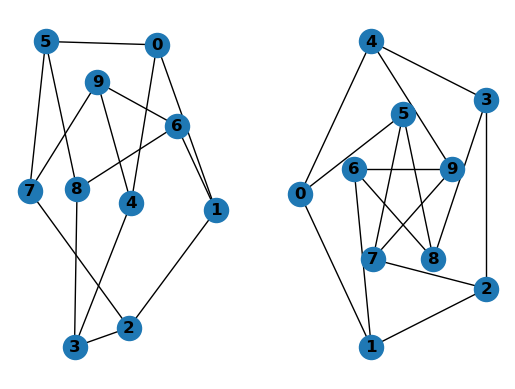

In [11]:
G = nx.petersen_graph()
subax1 = plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')
subax2 = plt.subplot(122)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

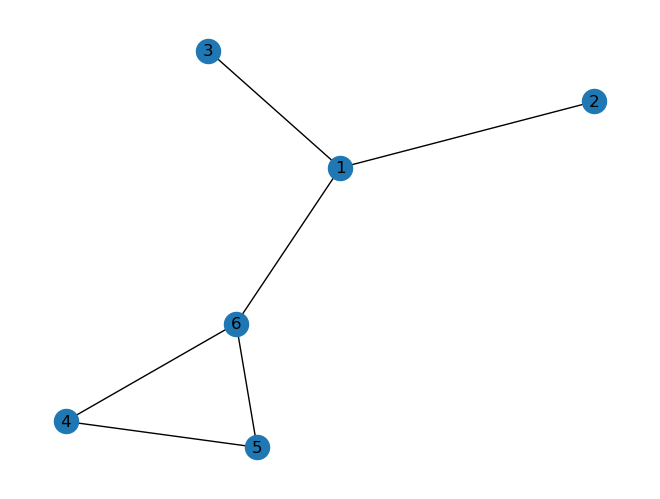

In [12]:
graph = nx.Graph()

graph.add_node(1, tile=MS_Tile(1))
graph.add_node(2, tile=MS_Tile(2))
graph.add_node(3, tile=MS_Tile(3))
graph.add_edge(1, 2)
graph.add_edge(1, 3)

graph.add_node(4, tile=MS_Tile(4))
graph.add_node(5, tile=MS_Tile(5))
graph.add_node(6, tile=MS_Tile(6))
graph.add_edge(4, 5)
graph.add_edge(4, 6)
graph.add_edge(6, 1)
graph.add_edge(5, 6)

nx.draw(graph, with_labels=True, pos=nx.spring_layout(graph))

In [13]:
graph.add_edge(4, 5, foo=[1,2])
for n in graph.edges:
    print(graph.edges[n])

{}
{}
{}
{'foo': [1, 2]}
{}
{}


In [14]:
from z3 import *

In [15]:
p = Bool('p')
q = Bool('q')
print (And(p, q, True))
print (simplify(And(p, q, True)))
print (simplify(And(p, False)))

And(p, q, True)
And(p, q)
False


In [20]:
def all_smt(s, initial_terms):
    def block_term(s, m, t):
        s.add(t != m.eval(t, model_completion=True))
    def fix_term(s, m, t):
        s.add(t == m.eval(t, model_completion=True))
    def all_smt_rec(terms):
        if sat == s.check():
           m = s.model()
           yield m
           for i in range(len(terms)):
               s.push()
               block_term(s, m, terms[i])
               for j in range(i):
                   fix_term(s, m, terms[j])
               yield from all_smt_rec(terms[i:])
               s.pop()   
    yield from all_smt_rec(list(initial_terms))

In [31]:
t0 = Bool("t0")
t10 = Bool("t10")

t1_cond = Or(And(t0, Not(t10)), And(Not(t0), t10))
s = Solver()
s.add(t1_cond)

In [32]:
for m in all_smt(s, [t0, t10]):
    print(m)

[t0 = False, t10 = True]
[t0 = True, t10 = False]


In [30]:
t1_cond

Or(And(t0, Not(t10), And(Not(t0), t10)))